# Exploration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split

In [1]:
def wrangle_grades():
    df = pd.read_csv('./student_grades.csv')
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df = df.dropna()
    df = df.astype('int')
    return df

In [4]:
df = wrangle_grades()

In [5]:
train, test = train_test_split(df, random_state=123, train_size=.8)

## Why Explore?

- What is the purpose of this pipeline stage?
- Why do we call it out explicitly?
- DIKW
- DIKIA (https://ds.codeup.com/fundamentals/DataToAction_v2.jpg)

In [6]:
df.head()

,student_id,exam1,exam2,exam3,final_grade
0,1,100,90,95,96
1,2,98,93,96,95
2,3,85,83,87,87
3,4,83,80,86,85
4,5,93,90,96,97


## Questions

- Is student_id unique?
- What's the relationship between individual exam scores and final grade? Probably fairly predictive
- Is there a cutoff in grade that makes sense to investigate? Passing/failing, letter grades?

In [11]:
df.student_id.value_counts().value_counts()

1    102
Name: student_id, dtype: int64

In [13]:
# Does each value uniquely identify a row?
df.student_id.nunique() == df.shape[0]

True

In [16]:
df = df.drop(columns='student_id')

<AxesSubplot:>

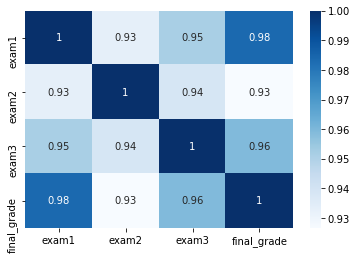

In [24]:
correlation_table = df.corr()
# sns.heatmap(correlation_table, cmap='Blues', annot=True, vmin=0, vmax=1)
sns.heatmap(correlation_table, cmap='Blues', annot=True)

* Exam 1 seems to be the most predictive of final grade
* Everything seems to correlate with everything (Multicolinearity)

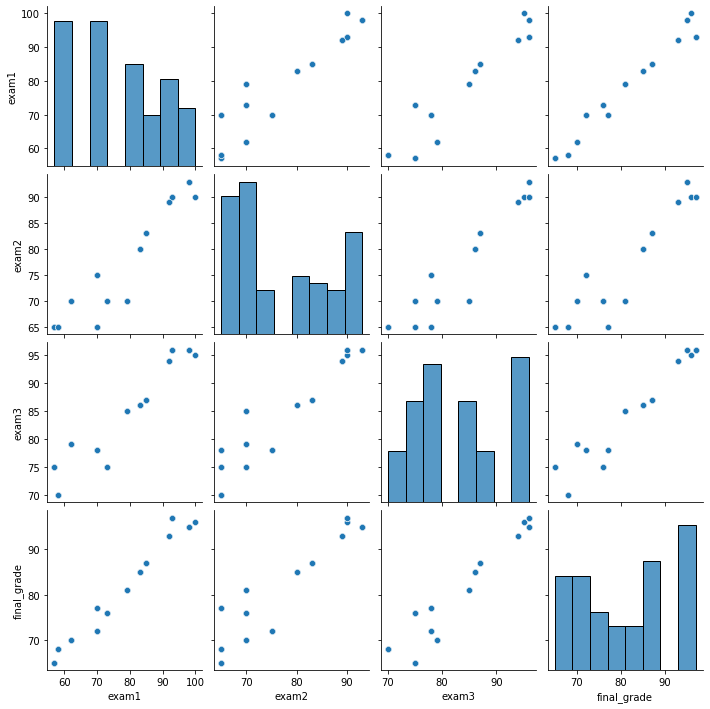

In [26]:
sns.pairplot(train.drop(columns='student_id'))

* Lots of linear relationships between exams
* Exam scores aren't all normally distributed
* It looks like the distribution of exam 2 scores is bimodal -- there's two peaks in the distribution

<AxesSubplot:ylabel='Frequency'>

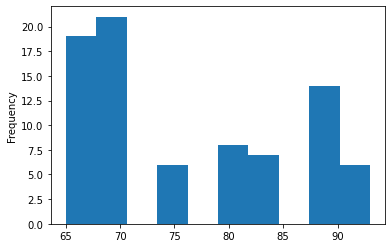

In [28]:
train.exam2.plot.hist()

In [29]:
train.exam2.value_counts(bins=[0, 75, 100])

(-0.001, 75.0]    46
(75.0, 100.0]     35
Name: exam2, dtype: int64

In [30]:
train['exam2_desc'] = np.where(train.exam2 > 75, 'good grade', 'bad grade')

<ipython-input-30-5a08ea837af0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['exam2_desc'] = np.where(train.exam2 > 75, 'good grade', 'bad grade')


<AxesSubplot:xlabel='final_grade', ylabel='Count'>

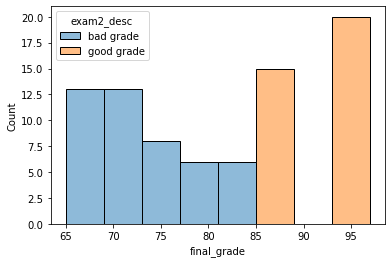

In [32]:
sns.histplot(data=train, x='final_grade', hue='exam2_desc')

In [33]:
train

,student_id,exam1,exam2,exam3,final_grade,exam2_desc
86,87,70,65,78,77,bad grade
21,22,70,65,78,77,bad grade
31,32,79,70,85,81,bad grade
33,34,73,70,75,76,bad grade
102,103,57,65,75,65,bad grade
...,...,...,...,...,...,...
85,86,73,70,75,76,bad grade
19,20,92,89,94,93,good grade
100,101,62,70,79,70,bad grade
94,95,83,80,86,85,good grade


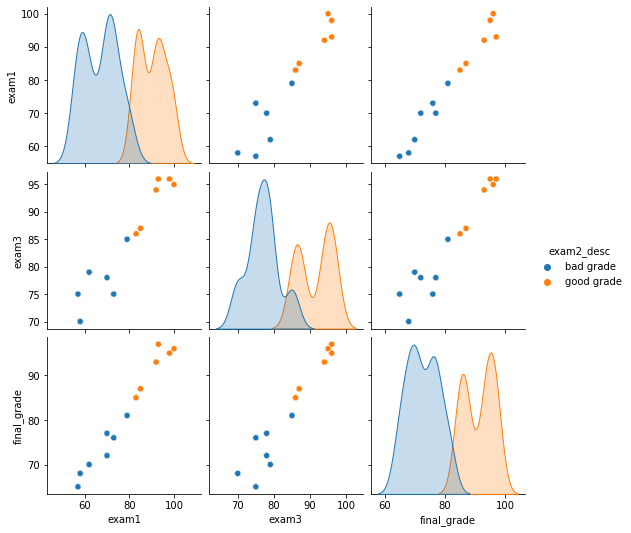

In [34]:
sns.pairplot(train.drop(columns=['student_id', 'exam2']), hue='exam2_desc')

<AxesSubplot:ylabel='Frequency'>

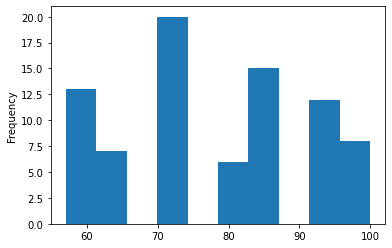

In [36]:
train.exam1.plot.hist()

In [38]:
train.exam1.value_counts(bins=[0, 75, 100])

(75.0, 100.0]     41
(-0.001, 75.0]    40
Name: exam1, dtype: int64

In [41]:
train['exam1_desc'] = np.where(train.exam1 > 75, 'good grade', 'bad grade')

<ipython-input-41-28d5ee1caa3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['exam1_desc'] = np.where(train.exam1 > 75, 'good grade', 'bad grade')


In [43]:
train.groupby('exam1_desc').final_grade.mean()

exam1_desc
bad grade     71.450000
good grade    89.682927
Name: final_grade, dtype: float64

Takeaways:

* Students that perform well on exam 1 (> a 75) go on to have a average of 90 for their final grade
* Students that perform poorly on exam 1 (<= a 75) go on to, on average, just barely pass the class

In [47]:
# How many people fail?
(train.final_grade < 70).mean()

0.16049382716049382

In [48]:
train['fails_class'] = train.final_grade < 70

<ipython-input-48-aeced2f0d9c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fails_class'] = train.final_grade < 70


In [49]:
pd.crosstab(train.exam1_desc, train.fails_class)

fails_class,False,True
exam1_desc,,
bad grade,27,13
good grade,41,0


Nobody who got a good grade on exam 1 went on to fail the class.

In [50]:
pd.crosstab(train.exam1_desc, train.fails_class, normalize='index')

fails_class,False,True
exam1_desc,,
bad grade,0.675,0.325
good grade,1.000,0.000


* Almost a third (32.5%) of students who get a bad grade (<= 75) on the first exam end up failing the class.

This suggests we can intervene in students likely to fail by taking a look at the score on the first exam.